# Mod 4 CRISP-DM Lab

## Objectives

By the end of this lab you will be able to:
- Understand the steps of the CRISP-DM model
- Apply the steps of the CRISP-DM model to a business problem using hyperparameter-tuned tree-based classification models

## CRoss-Industry Standard Process for Data Mining (CRISP-DM)

Before we dig into the problem, lets refresh our memories on the steps in the CRISP-DM model.

<img src="img/new_crisp-dm.png" width="500">

### The Data

<img src="img/grocery-cart.jpg" width="500">

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities.

The data is located in the csv called `big_mart.csv`

### Step 1: Business Understanding

We previously explored the features of the big_mart dataset but now BigMart wants us to answer the following question:

**The sales team at BigMart wants to hire someone to build a machine learning algorithm to predict whether products they sell will have high sales.  They have opened the dataset to competing consulting firms for their contract.  The winning firm will be the firm with the machine learning model which best minimizes the false positives in the _high_ class.**


### Step 2: Data Understanding

We have already done a great deal of exploratory data analysis of this dataset.  Let's refresh out memory on what the original data contained. 

<img src="img/big_mart_data_variables.png" width="500">

### Step 3: Data Preparation

This step has already been done for you.  The following steps were taken and are reflected in the `big_mart_clean.csv` file.

- Imputed missing values for `Outlet_Size` (replaced missing with the mode)
- Imputed missing values for `Item_Weight` (replaced missing with the average)
- Created a dichotomous variable `Item_Sales_Cat` for high (greater than 2500 in  sales), medium (1500-2499), or low (less than 1500 in sales)
- Cleaned typos in `Item_Fat_Content`
- Created new variable `Item_Type_Combined` (labels items as food, non-consumable, or drinks)
- Created new variable `Outlet_Years` (the years of operation of a store)


#### Before we begin modeling let's do a quick exploration of out new dataset!

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import ConfusionMatrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#explore the dataset
big_mart = pd.read_csv('big_mart_clean_3_classes.csv')


In [3]:
big_mart.shape

(8523, 13)

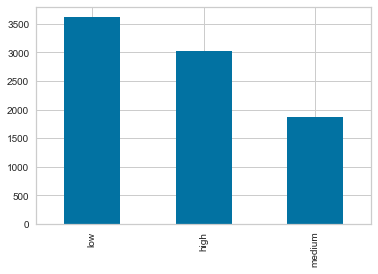

In [4]:
#let's look at the target variable (Item_Sales_Cat) a little more in depth to examine the classes
big_mart.Item_Sales_Cat.value_counts().plot(kind='bar')


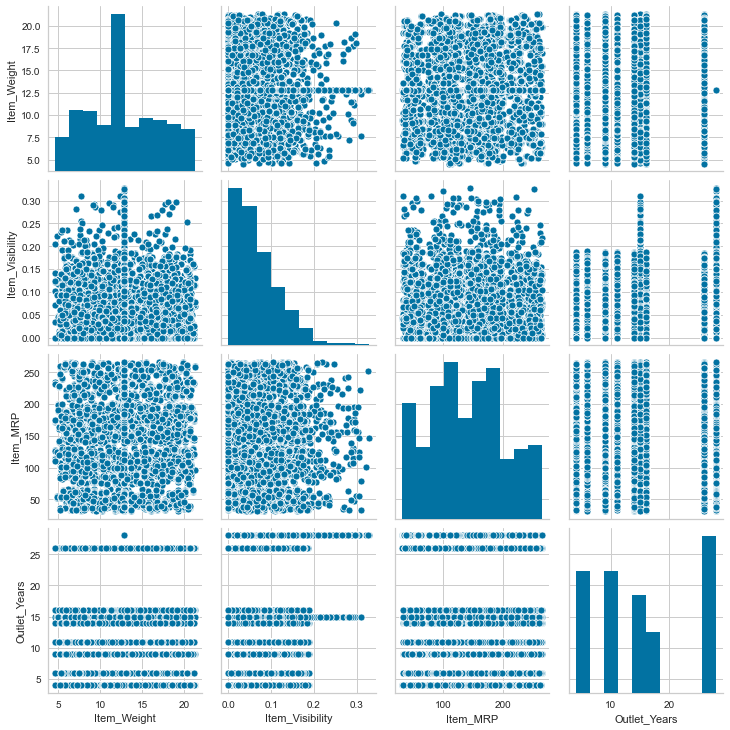

In [5]:
#let's also look at a pairplot of our dataset 
sns.pairplot(big_mart)


### Step 4: Modeling

In an effort to become more "green" BigMart swears by tree-based models.  They are only giving the contract to the firm which creates the "best" tree-based model for them.



<img src="img/talking.jpeg" width="60" align='left'>

<br>
<br>

#### Turn and Talk
- Given BigMart's "green" initiative, which models can our firm attempt to use?
- What hyperparameters are associated with each of those models?
- What are the weaknesses of each of these models?

#### Data preparation

Before we begin modeling let's split our data and then perform encoding/scaling steps.

In [6]:
#set random state for our notebook
import numpy as np
np.random.seed(217)

y = big_mart['Item_Sales_Cat']
X = big_mart.drop(columns=['Item_Sales_Cat', 'Item_Identifier'])

#split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)


In [7]:
#get shape of the training and test sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6392, 11), (6392,), (2131, 11), (2131,))

In [8]:
### Add code here
numeric_features = ['Item_Weight', 'Item_Visibility',
                     'Item_MRP', 'Outlet_Years']
ss=StandardScaler()

categorical_features = [ 'Item_Fat_Content',
       'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Type_Combined' ]

categorical_transformer = Pipeline(steps=[
    ("ordinal", OrdinalEncoder()),
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', ss, numeric_features),
        ('cat', categorical_transformer, categorical_features)], remainder='passthrough')

#let's use it now!

X_train_tran = preprocessor.fit_transform(X_train)
X_train_tran

#and we can transform X_test too

X_test_tran = preprocessor.transform(X_test)
X_test_tran

<2131x46 sparse matrix of type '<class 'numpy.float64'>'
	with 23441 stored elements in Compressed Sparse Row format>

In [9]:
#get column names for categories
cat_names = preprocessor.named_transformers_['cat'].named_steps['ordinal'].categories_

cat_names = [val for sublist in cat_names for val in sublist]
cat_names

#full list of column names
column_names = numeric_features + cat_names

#apply column names to dataframe
X_train_trans = pd.DataFrame.sparse.from_spmatrix(X_train_tran, columns=column_names)
X_train_trans.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Low Fat,Non-Edible,Regular,Baking Goods,Breads,Breakfast,...,Tier 1,Tier 2,Tier 3,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3,Drinks,Food,Non-Consumable
0,-1.036915,-0.972700,0.824790,-1.341284,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.378661,-0.223000,-0.764420,-0.148401,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.011160,1.071408,-1.309291,1.521635,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.933487,-0.723034,0.085657,1.283059,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.895380,-0.073697,-1.289446,-1.341284,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Dummy Model

First we are going to start with a dummy model to predict if the product has high or low sales. In our dummy model we classify everything as the majority class.
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [10]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_tran, y_train)
dummy.score(X_train_tran, y_train)

0.4300688360450563

<img src="img/talking.jpeg" width="60" align='left'>
<br>
<br>

#### Turn and Talk

- What does the score from this model tell us?
- What additional metrics do we want to examine?

Now that we have run our dummy model let's create a nice looking confusion matrix using the [yellowbrick package](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


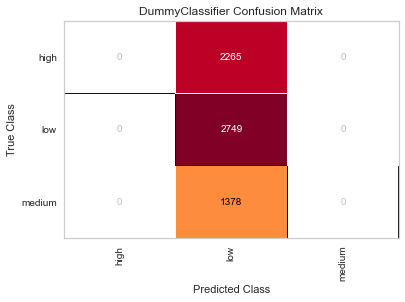

              precision    recall  f1-score   support

        high       0.00      0.00      0.00      2265
         low       0.43      1.00      0.60      2749
      medium       0.00      0.00      0.00      1378

    accuracy                           0.43      6392
   macro avg       0.14      0.33      0.20      6392
weighted avg       0.18      0.43      0.26      6392



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
cm = ConfusionMatrix(dummy)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_train_tran, y_train)

# How did we do?
cm.poof()

#specify the target classes
#classes = ["unoccupied", "occupied"]

# Instantiate the classification model and visualizer
y_pred=dummy.predict(X_train_tran)
print(classification_report(y_train, y_pred))

#### "Vanilla" Decision Tree

Now that we know what our dummy/baseline classifier does let's fit a "vanilla" Decision Tree Model

In [17]:
#your code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_tran, y_train)
tree_clf.score(X_train_tran, y_train)

1.0

### Step 5: Evalution

During the evaluation step we want to evaluate the results of our models, and decide the next steps in selecting the "best" model.  During this step we should consider the following:

- Does our model solve the business problem?
- What metrics should we be using to evaluate the "success" of our model?
- Can we further improve our models?
- Do we need more data?  Or different data?

In [18]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(tree_clf, X_train_tran, y_train, cv=5)
cv

array([0.61610633, 0.59265051, 0.60485133, 0.61032864, 0.6056338 ])

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
param_grid = {'max_depth':[5,10,15],
              'min_samples_leaf':[20,30,40],
              'max_features':['sqrt','log']}
y_pred = tree_clf.predict(X_train_tran)
precision = precision_score(y_train, y_pred, average='micro')
random_search = RandomizedSearchCV(tree_clf, param_grid, scoring=precision)
random_search.fit(X_train)

ValueError: scoring should either be a single string or callable for single metric evaluation or a list/tuple of strings or a dict of scorer name mapped to the callable for multiple metric evaluation. Got 1.0 of type <class 'numpy.float64'>



#### Your Turn!!

Using any other tree based model and hyperparameter tuning, can your group come up with the best model for predicting the items with high sales.

####  OK now let's test out your best models and evaluate it with the test data to see who has the "best" model.

In [ ]:
best_model = #your code for best model here
best_model.fit(X_train_tran, y_train)
best_model.score(X_test_tran, y_test)


cm = ConfusionMatrix(best_model)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_tran, y_test)

# How did we do?
cm.poof()

#specify the target classes
#classes = ["unoccupied", "occupied"]

# Instantiate the classification model and visualizer
y_pred=best_mosel.predict(X_train_tran)
print(classification_report(y_test, y_pred))